In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import  preprocessing
from datetime import datetime
#To plot figs on jupyter
%matplotlib inline
# figure size in inches
sns.set(rc={'figure.figsize':(24, 8)})


# W207 Final Project: <br> Lending Club Loan Data Default Classification
Michael Zeng, Param Viswanathan

# Introduction

* Our goal is the analyze the loan data and train a model to identify if the next loan applicant will default or not.
* We will be assigning a risk factor of high, medium and low based on the characteristics of the loan and the loan applicant
* We will divide the data set into 3 parts
    * Training data
    * Dev data
    * Test data


* We will first do EDA on the data to understand it better and then decide on how to clean up the data and also transform any values for certain features
* We will be evaluating various machine learning classifiers
    * Logistic Regression
    * K-means
    * Naive Bayesian
    * K-means Clustering
    * Gaussian Mixture Model

# Loading Data and Visualization

## Download the Data 

In [5]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('wendykan/lending-club-loan-data', 
                                  path='/Users/zengm71/Documents/Berkeley/\
                                        W207/ucb-w207-applied-ml/projects/\
                                        lending_club/', 
                                  unzip=True)


In [6]:
df = pd.read_csv("loan.csv", low_memory=False)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Visualization

In this section, we try to visualized the data to get an idea of the features available. 

We referenced some of the EDA by `Janio Martinez Bachmann` in his notebook https://www.kaggle.com/janiobachmann/lending-club-risk-analysis-and-metrics. 

* Loan Amount 

Text(0.5, 1.0, 'Loan Amount Applied by the Borrower')

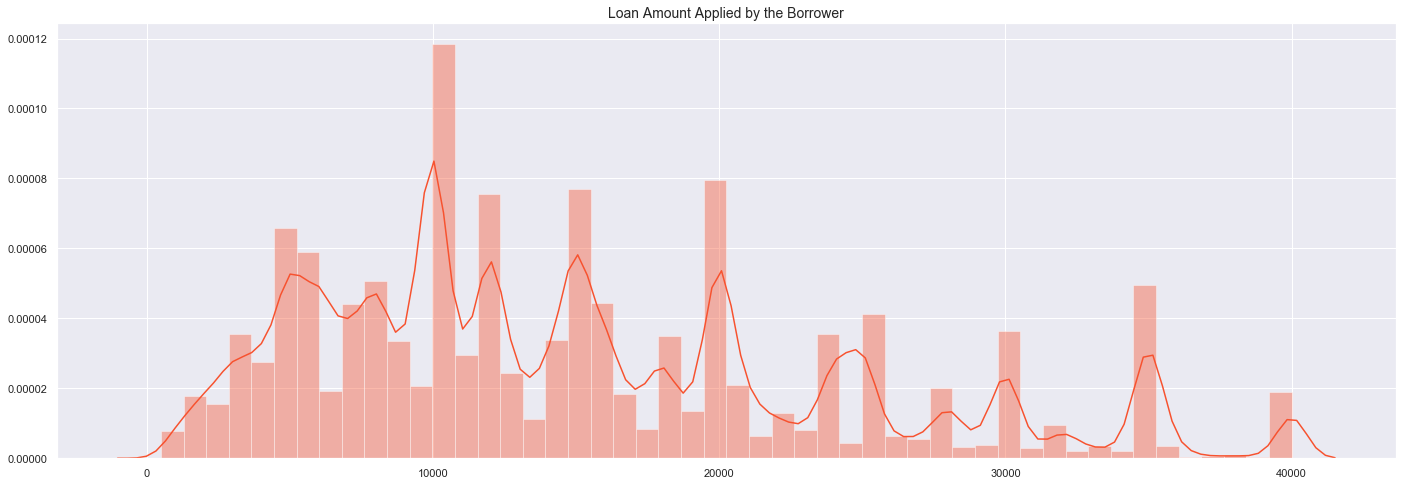

In [7]:
fig, ax = plt.subplots(1, figsize=(24,8))
df['year'] = pd.to_datetime(df['issue_d']).dt.year
loan_amount = df["loan_amnt"].values
sns.distplot(loan_amount, color="#F7522F")
ax.set_title("Loan Amount Applied by the Borrower", fontsize=14)

* Rating Grade

Text(0.5, 1.0, 'Rating Grades by the Borrower')

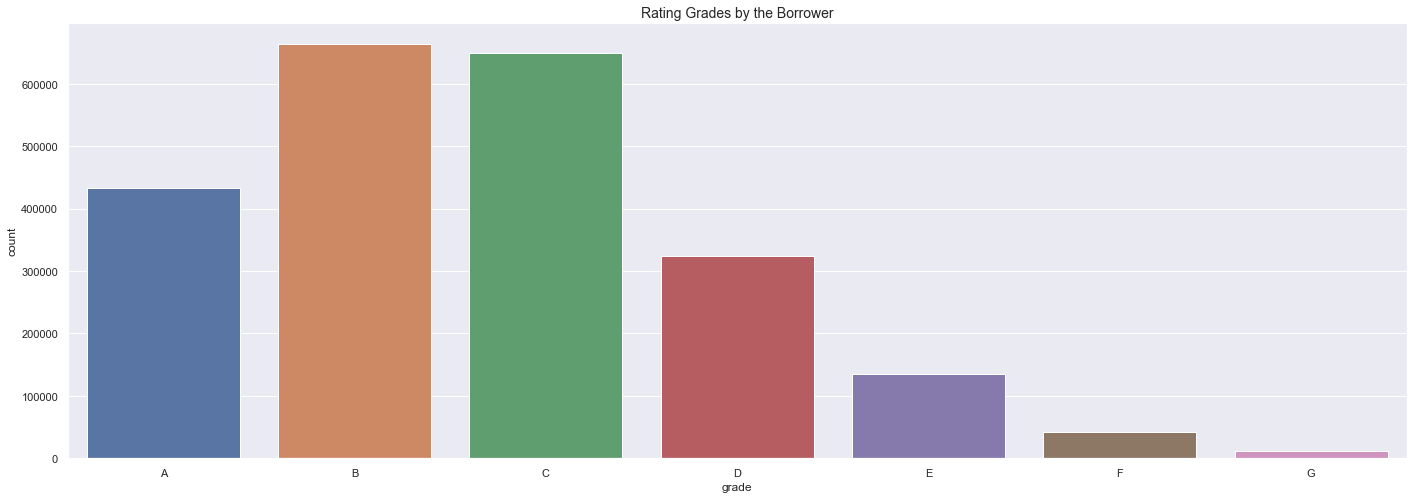

In [8]:
fig, ax = plt.subplots(1, figsize=(24,8))
sns.countplot(x = 'grade', data=df, 
              order= ['A', 'B', 'C', 'D', 'E', 'F', 'G'])
ax.set_title("Rating Grades by the Borrower", fontsize=14)

* Fine Rating Grade

Text(0.5, 1.0, 'Fine Rating Grades by the Borrower')

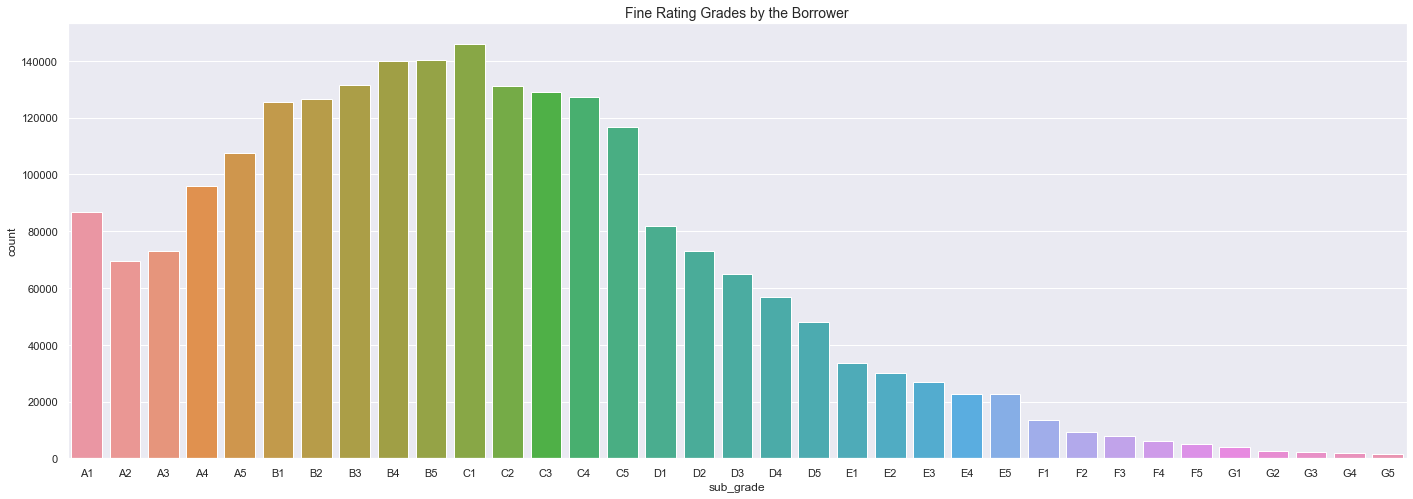

In [9]:
fig, ax = plt.subplots(1, figsize=(24,8))
sns.countplot(x = 'sub_grade', data=df, 
              order=np.sort(df.sub_grade.unique()))
ax.set_title("Fine Rating Grades by the Borrower", fontsize=14)

* Interest Rate

Text(0.5, 1.0, 'Interest Rates by Credit Score')

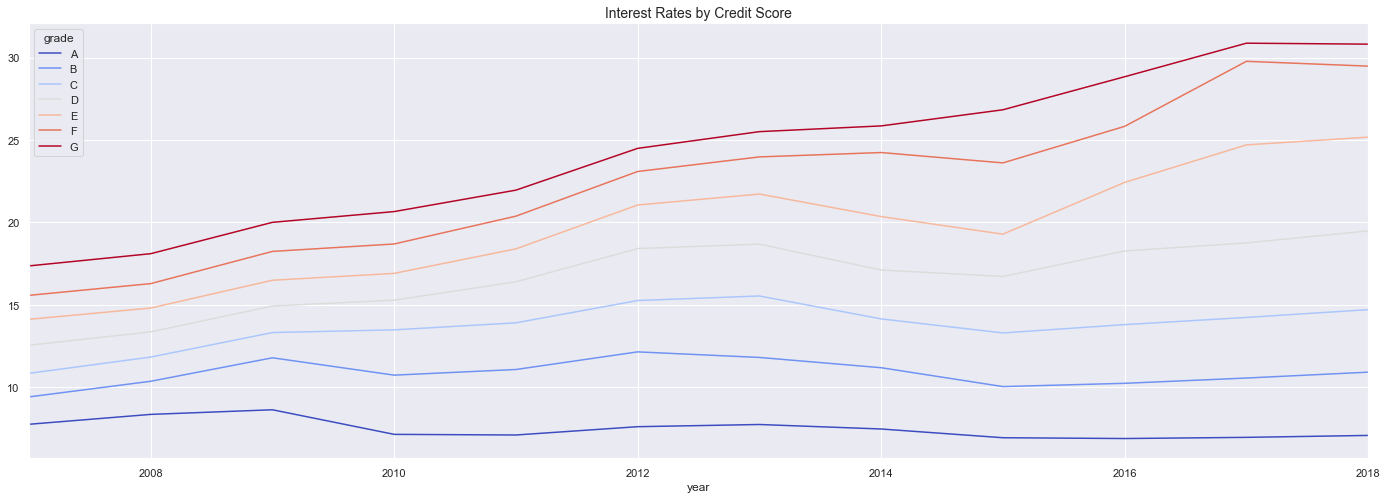

In [10]:
f, ax = plt.subplots(1, figsize=(24,8))
cmap = plt.cm.coolwarm

by_inc = df.groupby(['year', 'grade']).int_rate.mean()
by_inc.unstack().plot(ax=ax, colormap=cmap)
ax.set_title('Interest Rates by Credit Score', fontsize=14)

* Employment Length

Text(0.5, 0, 'Employment Length')

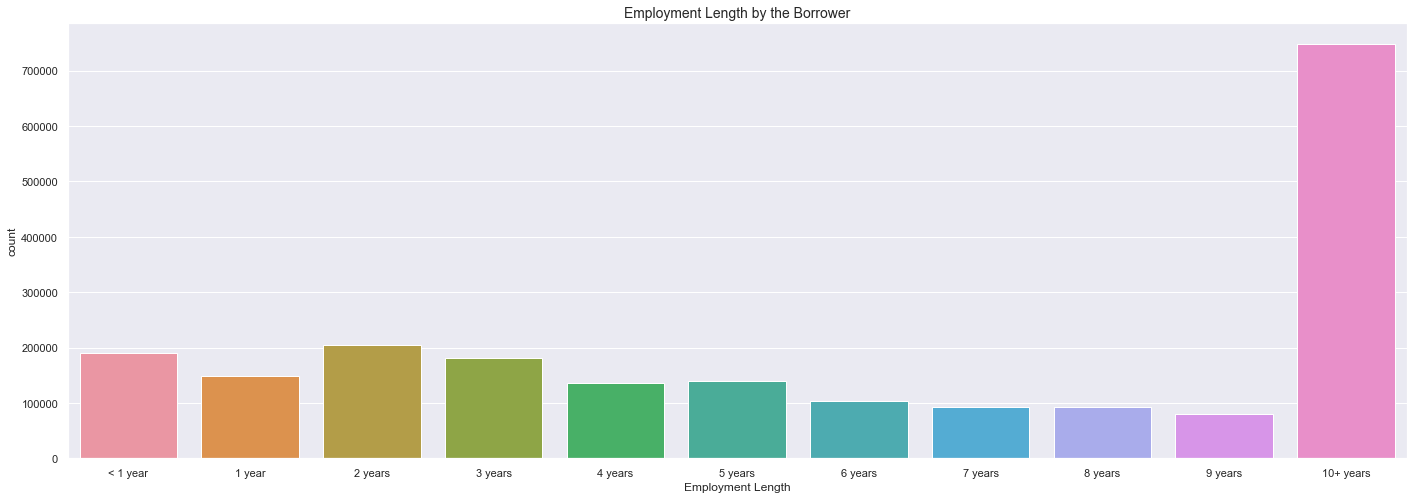

In [11]:
fig, ax = plt.subplots(1, figsize=(24,8))
sns.countplot(x = 'emp_length', data=df, 
              order = ['< 1 year', '1 year', '2 years', '3 years','4 years', '5 years', '6 years', '7 years', 
                      '8 years', '9 years', '10+ years'])
ax.set_title("Employment Length by the Borrower", fontsize=14)
plt.xlabel('Employment Length')

* Bad Loans

    There are 9 loan status labeled in the data:

In [12]:
df["loan_status"].value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

   For this project, we deem any loans NOT labeled either `Current` or `Fully Paid` as bad loans. 

   *Note that some of the loans are still within terms, and can potentially still default in the future. This is dealt with in the latter data cleaning section.* 


In [13]:
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]
df['loan_condition'] = np.nan
def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
df['loan_condition'] = df['loan_status'].apply(loan_condition)

[Text(0, 0.5, '(%)')]

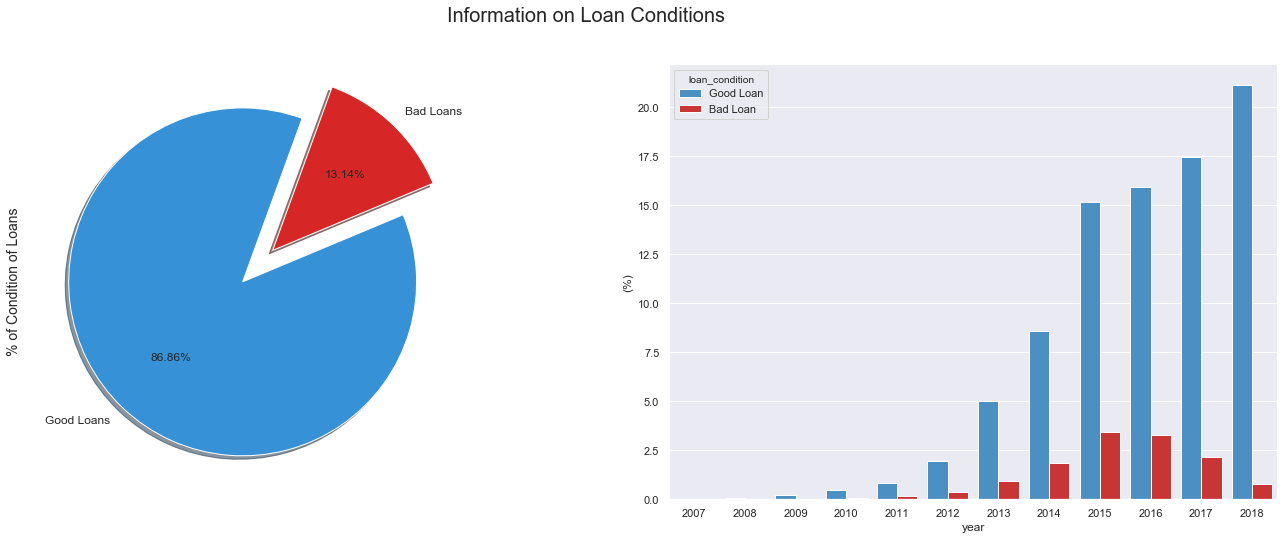

In [14]:
f, ax = plt.subplots(1,2, figsize=(24,8))
colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"
plt.suptitle('Information on Loan Conditions', fontsize=20)
df["loan_condition"].value_counts().plot.pie(explode=[0,0.25], 
                                             autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)
palette = ["#3791D7", "#E01E1B"]
sns.barplot(x="year", y="loan_amnt", hue="loan_condition", 
            data=df, palette=palette, 
            estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")

* With bad loans labeled, let's revisit the rating grade and interest rate, which are likely the two factors for default. 

Text(0.5, 1.0, 'Type of Loans by Sub-Grade')

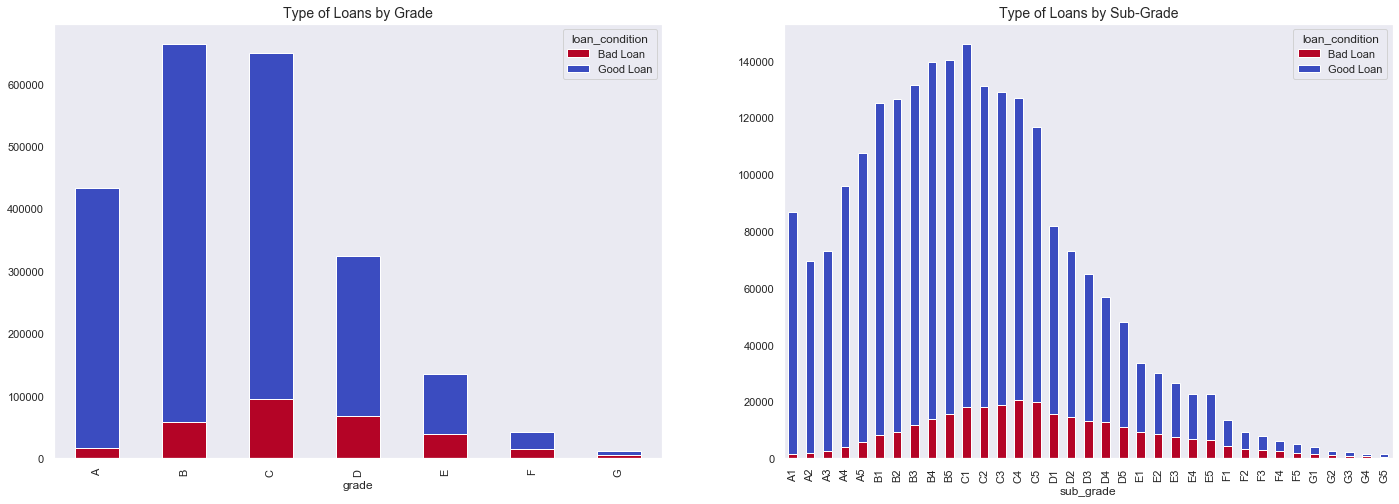

In [15]:
f, ax = plt.subplots(1,2, figsize=(24,8))
cmap = plt.cm.coolwarm_r
loans_by_region = df.groupby(['grade', 'loan_condition']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax[0], grid=False)
ax[0].set_title('Type of Loans by Grade', fontsize=14)
loans_by_grade = df.groupby(['sub_grade', 'loan_condition']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax[1], grid=False)
ax[1].set_title('Type of Loans by Sub-Grade', fontsize=14)

Text(0, 0.5, 'Interest Rate (%)')

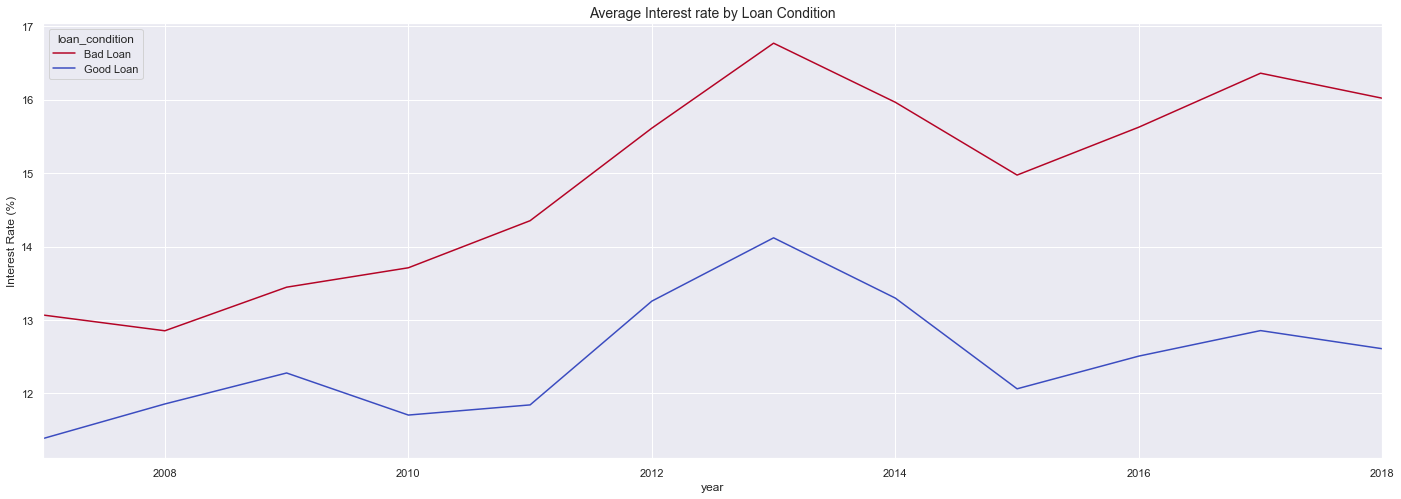

In [16]:
fig, ax = plt.subplots(1, figsize=(24,8))
by_interest = df.groupby(['year', 'loan_condition']).int_rate.mean()
by_interest.unstack().plot(ax=ax, colormap=cmap)
ax.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax.set_ylabel('Interest Rate (%)', fontsize=12)

# Data Cleaning

The data is updated 4 months ago. For loans issued recently that are still in term (not yet defaulted), we are not sure if they are going to default. So the first thing to do is to remove them so that we are left with a data set with reliable labels.

In [17]:
# the data set is as of 4 months ago
df['loan_age_months'] = df.issue_d.apply(lambda x: (datetime.now() - datetime.strptime(x, '%b-%Y')).days / 30) - 4
df['term_months'] = (df.term == ' 36 months') * 36 + (1 - (df.term == ' 36 months')) * 60
sum(df.term_months <= df.loan_age_months) / df.shape[0]

0.36529822158760156

This shows that about 64% of the loans are still within their terms. For these loans, unless they have already defaulted, we can't really trust the labels. We will remove the loans that might still default from our modeling dataset `df_m`. 

In [18]:
# loans still within loan term
df.loan_status[(df.term_months > df.loan_age_months)].value_counts()

Current               891262
Fully Paid            373839
Charged Off           136913
Late (31-120 days)     20712
In Grace Period         8519
Late (16-30 days)       3578
Default                   27
Name: loan_status, dtype: int64

In [19]:
# loans that are already done
df.loan_status[(df.term_months <= df.loan_age_months)].value_counts()

Fully Paid                                             668113
Charged Off                                            124742
Current                                                 28433
Does not meet the credit policy. Status:Fully Paid       1988
Late (31-120 days)                                       1185
Does not meet the credit policy. Status:Charged Off       761
In Grace Period                                           433
Late (16-30 days)                                         159
Default                                                     4
Name: loan_status, dtype: int64

In [20]:
bad_loan_status = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", 
                   "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]
might_still_default = (df.loan_status == 'Current') & (df.term_months > df.loan_age_months)

# data frame for modeling
df_m = df[~ might_still_default]
df_m.shape[0] / df.shape[0]

0.605752812885395

We are now left with about 60% of the original observations, for which we know the labels are trustworthy. 

In [21]:
df_m.loan_status.value_counts()

Fully Paid                                             1041952
Charged Off                                             261655
Current                                                  28433
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

## Take out columns with where majority of the observations are NAs


We plan to leave all the numerical features in, while one-hot encode all the categorical ones. 

In [22]:
df_m.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,year,loan_condition,loan_age_months,term_months
100,NaN,NaN,30000,30000,30000.0,36 months,22.35,1151.16,D,D5,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,Good Loan,4.166667,36
152,NaN,NaN,40000,40000,40000.0,60 months,16.14,975.71,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,Good Loan,4.166667,60
170,NaN,NaN,20000,20000,20000.0,36 months,7.56,622.68,A,A3,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,Good Loan,4.166667,36
186,NaN,NaN,4500,4500,4500.0,36 months,11.31,147.99,B,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,Good Loan,4.166667,36
215,NaN,NaN,8425,8425,8425.0,36 months,27.27,345.18,E,E5,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,Good Loan,4.166667,36


In [23]:
df_m = df_m.reindex()

In [24]:
df_m.dtypes

id                                            float64
member_id                                     float64
loan_amnt                                       int64
funded_amnt                                     int64
funded_amnt_inv                               float64
term                                           object
int_rate                                      float64
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

Let's take a look at the percentage of NAs in each column:

In [25]:
na_pct = df_m.isna().sum() / df_m.shape[0]
# we will simply remove the columns that are NA for more than 50% of the observations
df_m = df_m[na_pct[na_pct < 0.5].index]
df_m.shape

(1369406, 91)

We are now left from 89 columns from the starting 147 columns. Take a look at the NA percentages again:

In [26]:
na_pct = df_m.isna().sum() / df_m.shape[0]
na_pct.sort_values(ascending = False)

mths_since_recent_inq         0.130749
num_tl_120dpd_2m              0.089025
mo_sin_old_il_acct            0.079822
emp_title                     0.064516
emp_length                    0.059017
pct_tl_nvr_dlq                0.051431
avg_cur_bal                   0.051335
mo_sin_old_rev_tl_op          0.051319
mo_sin_rcnt_rev_tl_op         0.051319
num_rev_accts                 0.051319
num_rev_tl_bal_gt_0           0.051319
total_rev_hi_lim              0.051319
num_accts_ever_120_pd         0.051319
num_actv_bc_tl                0.051319
tot_cur_bal                   0.051319
num_actv_rev_tl               0.051319
num_il_tl                     0.051319
num_op_rev_tl                 0.051319
tot_coll_amt                  0.051319
mo_sin_rcnt_tl                0.051319
num_bc_tl                     0.051319
num_tl_30dpd                  0.051319
num_tl_90g_dpd_24m            0.051319
num_tl_op_past_12m            0.051319
total_il_high_credit_limit    0.051319
tot_hi_cred_lim          

## Deal with categorical variables


In [27]:
df_m.dtypes.sort_values().unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [28]:
df_m.dtypes

loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
term                           object
int_rate                      float64
installment                   float64
grade                          object
sub_grade                      object
emp_title                      object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                        object
loan_status                    object
pymnt_plan                     object
purpose                        object
title                          object
zip_code                       object
addr_state                     object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line               object
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal   

In [29]:
# columns that are integers
int_cols = list(df_m.dtypes[df_m.dtypes == 'int64'].index)
int_cols

['loan_amnt', 'funded_amnt', 'revol_bal', 'policy_code', 'year', 'term_months']

In [30]:
# columns that are floats
flt_cols = list(df_m.dtypes[df_m.dtypes == 'float64'].index)
flt_cols

['funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'p

In [31]:
# the rest of them are categorical, which are the ones we will try to encode
cat_cols = list(df_m.select_dtypes(include=['O']))
cat_cols

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag',
 'loan_condition']

* Term

In [32]:
# term
# create 1 variable for 36 months
print(df_m.term.value_counts())
df_m['term_cat'] = (df_m.term == ' 36 months') * 1
df_m.term_cat.value_counts()

 36 months    1036761
 60 months     332645
Name: term, dtype: int64


1    1036761
0     332645
Name: term_cat, dtype: int64

* Grade

In [33]:
# grade
# create 1 variable for each grade, and drop G to avoid perfect colinearity
print(df_m.grade.value_counts())

for grade_i in df_m.grade.unique():
    df_m['grade_' + grade_i + '_cat'] = (df_m.grade == grade_i) * 1
df_m.drop(columns= 'grade_G_cat', inplace=True)

B    396666
C    389871
A    236464
D    206992
E     96684
F     33113
G      9616
Name: grade, dtype: int64


* Home Ownership

In [34]:
# home_ownership
# create a variable for mortgage, rent and own each. 
# "ANY", "OTHER" and "NONE" will be be represented as the alternative
print(df_m.home_ownership.value_counts())

for home_ownership in ['MORTGAGE', 'RENT', 'OWN']:
    df_m['home_ownership_' + home_ownership + '_cat'] = (df_m.home_ownership == home_ownership) * 1

MORTGAGE    675501
RENT        545438
OWN         147942
ANY            290
OTHER          182
NONE            53
Name: home_ownership, dtype: int64


* Verification Status

In [35]:
# verification_status
# create a variable for 'Source Verified', 'Verified' each
print(df_m.verification_status.value_counts())

for verification_status_i in ['Source Verified', 'Verified']:
    df_m['verification_status_' + verification_status_i.replace(" ", "") + '_cat'] = \
    (df_m.verification_status == verification_status_i) * 1

Source Verified    531227
Verified           426392
Not Verified       411787
Name: verification_status, dtype: int64


* Employment Length

In [36]:
# emp_length 
print(df_m.emp_length.value_counts())

# transform emp_length into numerical 
def extract_emp_length(x):
    if str(x).split()[0] == 'nan':
        return(0)
    elif str(x).split()[0] == '<':
        return(1)
    elif str(x).split()[0] == '10+':
        return(10)
    else:
        return(int(str(x).split()[0]))
df_m['emp_length_num'] = df_m['emp_length'].apply(lambda x: extract_emp_length(x))

10+ years    449807
2 years      123689
< 1 year     110185
3 years      109529
1 year        90137
5 years       85602
4 years       81942
6 years       63843
8 years       61719
7 years       60409
9 years       51726
Name: emp_length, dtype: int64


* Purpose 

In [37]:
# purpose
print(df_m.purpose.value_counts())

# create one column for each purpose, and drop education
for purpose_i in df_m.purpose.unique():
    df_m['purpose_' + purpose_i + '_cat'] = (df_m.purpose == purpose_i) * 1

df_m.drop(columns= 'purpose_educational_cat', inplace=True)

debt_consolidation    793957
credit_card           299870
home_improvement       89019
other                  79823
major_purchase         29991
small_business         16033
medical                15901
car                    14802
moving                  9687
vacation                9198
house                   7401
wedding                 2350
renewable_energy         951
educational              423
Name: purpose, dtype: int64


* Hardship

In [38]:
# hardship
print(df_m.hardship_flag.value_counts())

# create a column for hardship
df_m['hardship_flag_cat'] = (df_m.hardship_flag == 'Y') * 1
df_m.hardship_flag_cat.value_counts()

N    1368531
Y        875
Name: hardship_flag, dtype: int64


0    1368531
1        875
Name: hardship_flag_cat, dtype: int64

## Drop columns that might imply defaults

* Debt Settlement 

In [39]:
# debt_settlement_flag
# drop settle_ment_flag, since one only settles when already in default. 
# for the same reason drop all the other columns about settlement

for i in df_m.columns:
    if 'settlement' in i:
        df_m.drop(columns= i, inplace=True)
        print('droped column ' + i)


droped column debt_settlement_flag


* Rocovery Flag

In [40]:
# rec_flag
# drop recovery related columns, because it happens after default
recoveries_col = ['total_rec_prncp', 'total_rec_int', 
                  'total_rec_late_fee', 'recoveries', 
                  'collection_recovery_fee']
for i in recoveries_col:
    df_m.drop(columns= i, inplace=True)
    print('droped column ' + i)


droped column total_rec_prncp
droped column total_rec_int
droped column total_rec_late_fee
droped column recoveries
droped column collection_recovery_fee


In [41]:
# loan_status
# set all bad loans as default and use that as the label of classification
df_m['default'] = df_m.loan_status.apply(lambda x: (x in bad_loan_status) * 1)
df_m['default'].value_counts()

0    1072373
1     297033
Name: default, dtype: int64

In [42]:
df_m.drop(columns = 'year', inplace = True)

## Now that we have encoded the categorical variables we want, we can select the numerical columns and use that for modeling

In [43]:
numeric_cols = list(df_m.dtypes[df_m.dtypes == 'int64'].index) + \
                list(df_m.dtypes[df_m.dtypes == 'float64'].index)
df_m_n = df_m[numeric_cols]
df_m_n.describe()

,loan_amnt,funded_amnt,revol_bal,policy_code,term_months,term_cat,grade_D_cat,grade_C_cat,grade_A_cat,grade_B_cat,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_age_months
count,1.369406e+06,1.369406e+06,1.369406e+06,1369406.0,1.369406e+06,1.369406e+06,1.369406e+06,1.369406e+06,1.369406e+06,1.369406e+06,...,1.299130e+06,1.298976e+06,1.304826e+06,1.368041e+06,1.369301e+06,1.299130e+06,1.319376e+06,1.319376e+06,1.299130e+06,1.369406e+06
mean,1.446531e+04,1.445664e+04,1.628472e+04,1.0,4.182989e+01,7.570881e-01,1.511546e-01,2.847008e-01,1.726763e-01,2.896628e-01,...,2.179124e+00,9.412474e+01,4.529152e+01,1.341736e-01,5.274954e-02,1.739687e+05,4.970461e+04,2.157050e+04,4.216039e+04,4.659230e+01
std,8.736521e+03,8.732758e+03,2.247955e+04,0.0,1.029222e+01,4.288424e-01,3.581996e-01,4.512720e-01,3.779674e-01,4.536060e-01,...,1.846343e+00,8.786840e+00,3.601876e+01,3.777502e-01,4.033272e-01,1.779088e+05,4.780187e+04,2.151212e+04,4.332570e+04,1.992600e+01
min,5.000000e+02,5.000000e+02,0.000000e+00,1.0,3.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.166667e+00
25%,8.000000e+03,8.000000e+03,5.943000e+03,1.0,3.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,9.130000e+01,1.110000e+01,0.000000e+00,0.000000e+00,4.947700e+04,2.088500e+04,7.700000e+03,1.471500e+04,3.360000e+01
50%,1.200000e+04,1.200000e+04,1.114100e+04,1.0,3.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.000000e+00,9.790000e+01,4.290000e+01,0.000000e+00,0.000000e+00,1.117385e+05,3.731100e+04,1.500000e+04,3.168500e+04,4.476667e+01
75%,2.000000e+04,2.000000e+04,1.977600e+04,1.0,3.600000e+01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,...,3.000000e+00,1.000000e+02,7.500000e+01,0.000000e+00,0.000000e+00,2.514750e+05,6.257600e+04,2.800000e+04,5.666700e+04,5.796667e+01
max,4.000000e+04,4.000000e+04,2.904836e+06,1.0,6.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,3.200000e+01,1.000000e+02,1.000000e+02,1.200000e+01,8.500000e+01,9.999999e+06,3.408095e+06,1.105500e+06,2.101913e+06,1.442000e+02


## Impute the rest of NAs with 0

In [44]:
na_pct = df_m_n.isna().sum() / df_m.shape[0]
na_pct[na_pct >0].sort_values()

annual_inc                    0.000003
delinq_2yrs                   0.000021
open_acc                      0.000021
pub_rec                       0.000021
total_acc                     0.000021
acc_now_delinq                0.000021
delinq_amnt                   0.000021
inq_last_6mths                0.000022
tax_liens                     0.000077
collections_12_mths_ex_med    0.000106
chargeoff_within_12_mths      0.000106
dti                           0.000265
revol_util                    0.000663
pub_rec_bankruptcies          0.000997
total_bal_ex_mort             0.036534
total_bc_limit                0.036534
mort_acc                      0.036534
acc_open_past_24mths          0.036534
num_sats                      0.042785
num_bc_sats                   0.042785
mths_since_recent_bc          0.046173
bc_open_to_buy                0.046857
percent_bc_gt_75              0.047159
bc_util                       0.047427
tot_coll_amt                  0.051319
tot_hi_cred_lim          

In [46]:
X = df_m_n.drop('default', axis=1)
y = df_m_n['default']

X[X.isna()]= 0

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = .2, 
                                                    random_state = 0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size = .2, 
                                                  random_state = 0)

scaler = preprocessing.Normalizer()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Logistic Regression
Use logistic regression as our base model. 

In [47]:
n_obs = X_train_scaled.shape[0]
lr_clf = LogisticRegression(random_state=0, 
                            max_iter = 1000, 
                            penalty = 'l1', 
                            C = .5)
lr_clf.fit(X_train_scaled[0:n_obs,], y_train[0:n_obs])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
predict_val = lr_clf.predict(X_val_scaled)
accuracy_val = metrics.accuracy_score(y_pred= predict_val, 
                                        y_true = y_val)
f1_val = metrics.f1_score(y_pred= predict_val, 
                            y_true = y_val)
        
print("The accuracy ratio of the validation sample is %.2f%%" %(accuracy_val * 100))
print("The f1 score of the validation sample is %.2f%%" %(f1_val * 100))

The accuracy ratio of the validation sample is 97.73%
The f1 score of the validation sample is 94.57%


Double check the weights to ensure that we didn't accidentally include some features that would leak information about the label, such as recoveries and settlements. 

In [49]:
lr_weights = pd.DataFrame({
    'feature' : X.columns[lr_clf.coef_[0] != 0], 'weights' : lr_clf.coef_[lr_clf.coef_ != 0]})
print(lr_weights.sort_values(by = 'weights'))

                       feature     weights
9              last_pymnt_amnt -183.333331
7                  total_pymnt -142.349399
8              total_pymnt_inv -135.110386
14              bc_open_to_buy   -7.212240
13                 avg_cur_bal   -4.873798
17              total_bc_limit   -1.067633
15             tot_hi_cred_lim   -0.989170
4                   annual_inc   -0.986686
18  total_il_high_credit_limit   -0.889670
2                    revol_bal   -0.048418
12            total_rev_hi_lim    0.066262
11                 tot_cur_bal    0.866730
10                tot_coll_amt    1.042034
16           total_bal_ex_mort    1.648442
0                    loan_amnt   18.401763
5                    out_prncp   35.064073
1                  funded_amnt  137.327549
6                out_prncp_inv  139.992069
3              funded_amnt_inv  157.949922


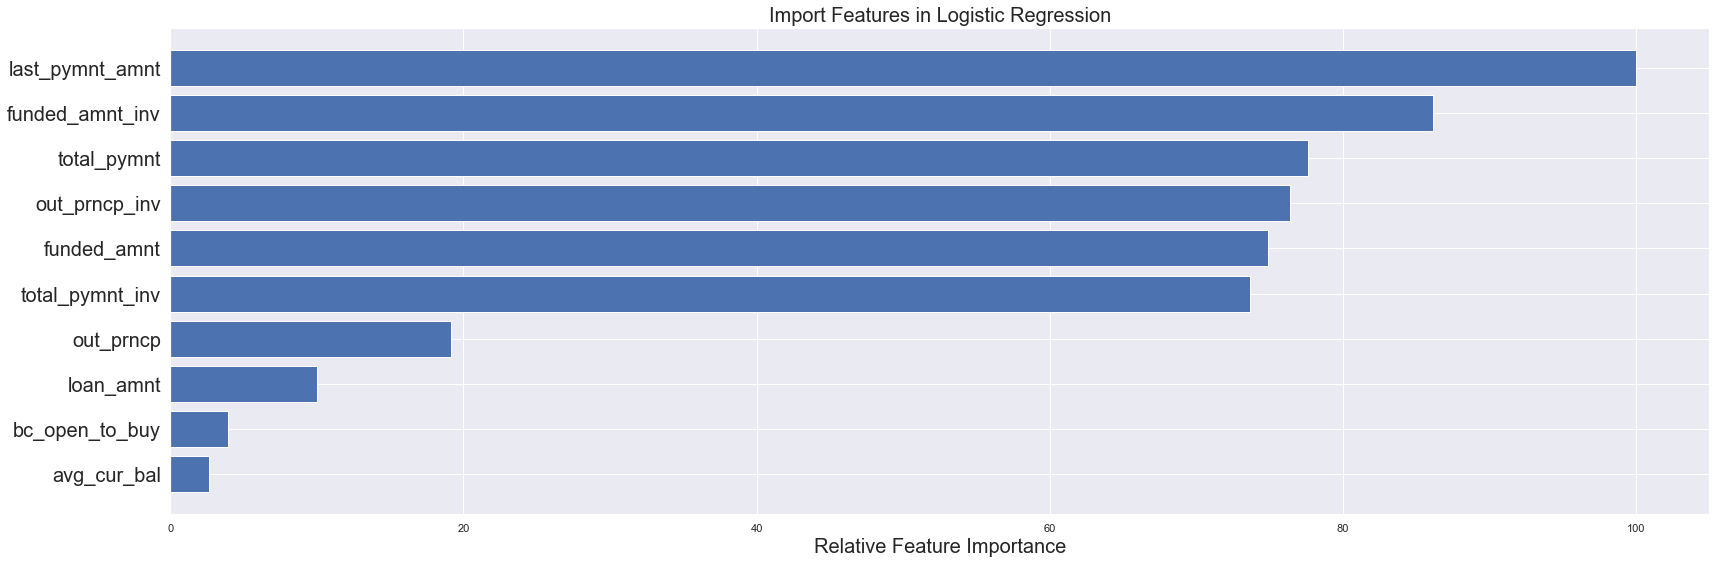

In [50]:
feature_importance = abs(lr_clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-10:]
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=20)
featax.set_xlabel('Relative Feature Importance', fontsize=20)
plt.title('Import Features in Logistic Regression', fontsize=20)
plt.tight_layout()   
plt.show()

# Random Forest

Try a random forest model, which is more scalable but needs tuning. 

In [51]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators = 50, random_state = 0)
rf_clf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [52]:
feature_imp = pd.Series(rf_clf.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

predict_val = rf_clf.predict(X_val_scaled)
accuracy_val = metrics.accuracy_score(y_pred= predict_val, 
                                        y_true = y_val)
f1_val = metrics.f1_score(y_pred= predict_val, 
                            y_true = y_val)
  
print("The accuracy ratio of the validation sample is %.2f%%" %(accuracy_val * 100))
print("The f1 score of the validation sample is %.2f%%" %(f1_val * 100))

The accuracy ratio of the validation sample is 98.62%
The f1 score of the validation sample is 96.73%


No handles with labels found to put in legend.


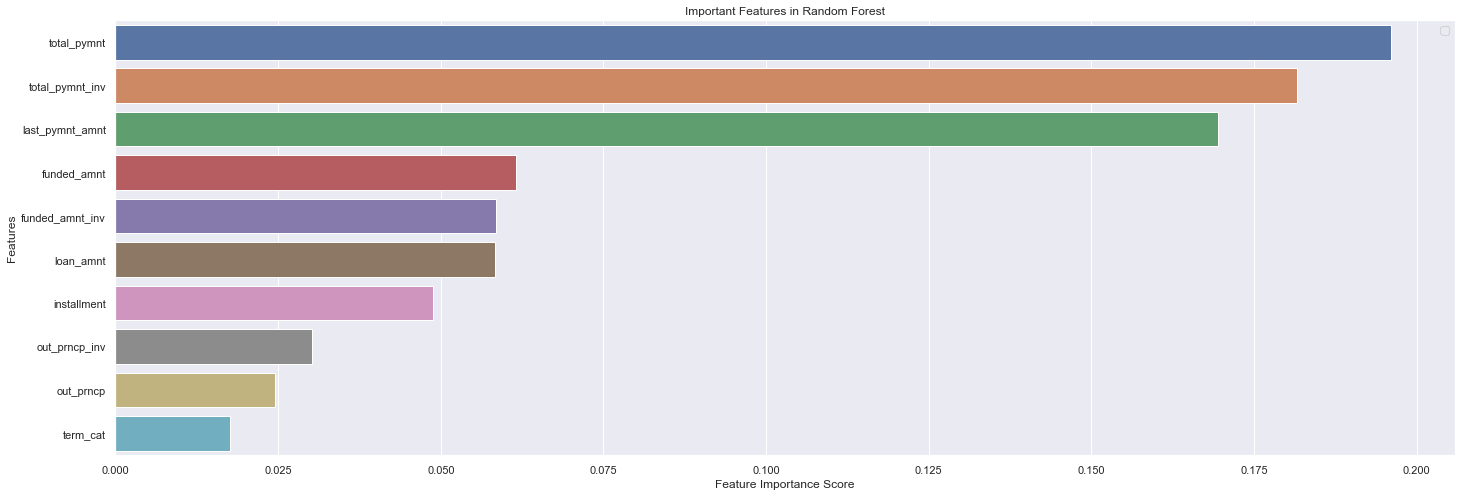

In [53]:
sns.barplot(x=feature_imp[0:10], y=feature_imp.index[0:10])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features in Random Forest")
plt.legend()
plt.show()

# Naive Bayesian with PCA

In [54]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.decomposition import PCA

pca_mod = PCA(n_components = 20)
pca_mod.fit(X_train_scaled)

X_train_projected = pca_mod.transform(X_train_scaled)
X_val_projected = pca_mod.transform(X_val_scaled)
X_test_projected = pca_mod.transform(X_test_scaled)

gnb_clf = GaussianNB(var_smoothing=.0001)
gnb_clf.fit(X_train_projected, y_train)

GaussianNB(priors=None, var_smoothing=0.0001)

In [55]:
predict_val = gnb_clf.predict(X_val_projected)
accuracy_val = metrics.accuracy_score(y_pred= predict_val, 
                                        y_true = y_val)
f1_val = metrics.f1_score(y_pred= predict_val, 
                            y_true = y_val)
print("The accuracy ratio of the validation sample is %.2f%%" %(accuracy_val * 100))
print("The f1 score of the validation sample is %.2f%%" %(f1_val * 100))

The accuracy ratio of the validation sample is 90.91%
The f1 score of the validation sample is 74.63%


# SVM

In [56]:
from sklearn.svm import LinearSVC
svm_clf = LinearSVC(C=1.0)
svm_clf.fit(X_train_scaled, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [57]:
predict_val = svm_clf.predict(X_val_scaled)
accuracy_val = metrics.accuracy_score(y_pred= predict_val, 
                                        y_true = y_val)
f1_val = metrics.f1_score(y_pred= predict_val, 
                            y_true = y_val)
  
print("The accuracy ratio of the validation sample is %.2f%%" %(accuracy_val * 100))
print("The f1 score of the validation sample is %.2f%%" %(f1_val * 100))

The accuracy ratio of the validation sample is 97.22%
The f1 score of the validation sample is 93.25%


# Neural Network

In [58]:
import keras 
import tensorflow as tf
import keras.backend as K
from keras.models import load_model
import h5py

Using TensorFlow backend.


In [59]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)


In [ ]:
nnet_clr = keras.Sequential()
nnet_clr.add(keras.layers.Dense(16, input_dim=X_train_scaled.shape[1], 
                activation='relu'))
nnet_clr.add(keras.layers.Dense(8, activation='relu'))
nnet_clr.add(keras.layers.Dense(1, activation='sigmoid'))
nnet_clr.compile(loss=f1_loss, 
              optimizer='adam', 
              metrics=['accuracy', f1])
hist = nnet_clr.fit(X_train_scaled, y_train, epochs=5, batch_size=10,
                   validation_data = (X_val_scaled, y_val))

In [ ]:
# save model
nnet_clr.save_weights('nnet_model.h5')

In [63]:
# load model
model = keras.Sequential()
model.add(keras.layers.Dense(12, input_dim=X_train_scaled.shape[1], 
                activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.load_weights('nnet_model.h5')
nnet_clr = model

In [64]:
predict_val = nnet_clr.predict(X_val_scaled)
predict_val = (predict_val > .5)
accuracy_val = metrics.accuracy_score(y_pred = predict_val, 
                                      y_true = y_val)
f1_val = metrics.f1_score(y_pred = predict_val, y_true = y_val)

print("The accuracy ratio of the validation sample is %.2f%%" %(accuracy_val * 100))
print("The f1 score of the validation sample is %.2f%%" %(f1_val * 100))

The accuracy ratio of the validation sample is 97.73%
The f1 score of the validation sample is 94.50%


# Model Comparison

So far, we have trained and tested 5 models on the training set, and scored on the testing set. Now we compare them by scoring the test set, and compare the `f1` scores. 

In [65]:
# Logistic Regression
predict_test_lr = lr_clf.predict(X_test_scaled)
f1_test_lr = metrics.f1_score(y_pred = predict_test_lr, y_true = y_test)

# Random Forest
predict_test_rf = rf_clf.predict(X_test_scaled)
f1_test_rf = metrics.f1_score(y_pred = predict_test_rf, y_true = y_test)

# Naive Bayesian with 
predict_test_nb = gnb_clf.predict(X_test_projected)
f1_test_nb = metrics.f1_score(y_pred = predict_test_nb, y_true = y_test)

# SVM
predict_test_svm = svm_clf.predict(X_test_scaled)
f1_test_svm = metrics.f1_score(y_pred = predict_test_svm, y_true = y_test)

# Neural Network
predict_test_nnet = nnet_clr.predict(X_test_scaled)
predict_test_nnet = (predict_test_nnet > .5)
f1_test_nnet = metrics.f1_score(y_pred = predict_test_nnet, y_true = y_test)

In [66]:
comparison = pd.DataFrame({'Models': ['LogisticRegression', 'Random Forest', 'Naive Bayesian with PCA', 
                                      'SVM', 'Neural Network'], 
                           'F1 Score': [f1_test_lr, f1_test_rf, f1_test_nb, f1_test_svm, f1_test_nnet]})
print(comparison)

                    Models  F1 Score
0       LogisticRegression  0.944759
1            Random Forest  0.966795
2  Naive Bayesian with PCA  0.744783
3                      SVM  0.931911
4           Neural Network  0.945154
